In [1]:
%matplotlib inline

In [2]:
#-------------------------------------------------------------------------------------------------------------------------------
# By Alexandra Lee (Septermber 2018) 
#
# Generate input files
#
# Dataset: Pseudomonas aeruginosa gene expression compendium referenced in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/
# 
# Group samples based on gene expression of PA1673
#
# Generate offset vector using extreme gene expression values (train_offset_original):
# average highest gene expression - average lowest gene expression 
#-------------------------------------------------------------------------------------------------------------------------------
import os
import pandas as pd
import numpy as np
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

randomState = 123
from numpy.random import seed
seed(randomState)

In [3]:
# Load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")  # repo file is zipped
gene_id = "PA1673"

# Output training
train_highest_file = os.path.join(os.path.dirname(os.getcwd()), "data", "PA1673_full_old", "train_highest_PA1673.txt")
train_lowest_file = os.path.join(os.path.dirname(os.getcwd()), "data", "PA1673_full_old", "train_lowest_PA1673.txt")
train_input_file = os.path.join(os.path.dirname(os.getcwd()), "data", "PA1673_full_old", "train_model_input.txt.xz")

# Output test
test_lowest_file = os.path.join(os.path.dirname(os.getcwd()), "data", "PA1673_full_old", "test_lowest_PA1673.txt")
test_mid1_file = os.path.join(os.path.dirname(os.getcwd()), "data", "PA1673_full_old", "test_mid1_PA1673.txt")
test_mid2_file = os.path.join(os.path.dirname(os.getcwd()), "data", "PA1673_full_old", "test_mid2_PA1673.txt")

# Output offset
original_offset_file = os.path.join(os.path.dirname(os.getcwd()), "data", "PA1673_full_old", "train_offset_original.txt")

In [4]:
# Read in data
data = pd.read_table(data_file, header = 0, sep = '\t', index_col = 0, compression='zip')
X = data.transpose()
X.shape

(1191, 5549)

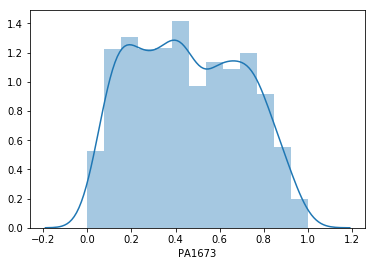

In [5]:
# Plot distirubtion of gene_id gene expression 
sns.distplot(X[gene_id])

In [6]:
# Collect the extreme gene expressions
highest = X[X[gene_id] >= np.percentile(X[gene_id], 95)]
lowest = X[X[gene_id] <= np.percentile(X[gene_id], 5)]

In [7]:
# Checkpoint
print(highest.shape)
print(lowest.shape)

(60, 5549)
(60, 5549)


In [8]:
# Checkpoint
print(np.percentile(X[gene_id], 95))
print(highest[gene_id])
print(np.percentile(X[gene_id], 5))
print(lowest[gene_id])

0.860280993858
GSM1143378_B1_Pae_G1a_.CEL                                    0.892186
GSM1143380_B3_Pae_G1a_.CEL                                    0.870005
GSM1237737_M9_PAOSX_1_51059600653060050411410396750419.CEL    0.939677
GSM1237738_M9_PAOSX_3_51059600653060050411410396750359.CEL    0.910555
GSM1237739_M9_PAOSX_4_51059600653061050411410396750526.CEL    0.876537
GSM1246482_PA14bvlR_pME6032_rep2.CEL                          0.870267
GSM1246486_PA14bvlR_pMEbvlR_rep3.CEL                          0.903608
GSM1267091_HZI1954_Pae_G1a.CEL                                0.915225
GSM1267093_HZI1956_Pae_G1a.CEL                                0.939142
GSM1267094_HZI1958_Pae_G1a.CEL                                0.927052
GSM1267095_HZI1959_Pae_G1a.CEL                                0.954175
GSM1267096_HZI1960a_Pae_G1a.CEL                               0.983001
GSM1267097_HZI1961_Pae_G1a.CEL                                0.917888
GSM1267098_HZI1962_Pae_G1a.CEL                                

In [9]:
# Create dataframes with intermediate gene expression levels
baseline = X[(X[gene_id] > np.percentile(X[gene_id], 5)) & (X[gene_id] <= np.percentile(X[gene_id], 10))]
mid_1 = X[(X[gene_id] > np.percentile(X[gene_id], 40)) & (X[gene_id] <= np.percentile(X[gene_id], 50))]
mid_2 = X[(X[gene_id] > np.percentile(X[gene_id], 70)) & (X[gene_id] <= np.percentile(X[gene_id], 80))]

In [10]:
# Checkpoint
print(baseline.shape)
print(mid_1.shape)
print(mid_2.shape)

(60, 5549)
(119, 5549)
(119, 5549)


In [11]:
# Create input to VAE using all samples and holding out intermediate and baseline samples
input_holdout = (
    X
    .drop(baseline.index)
    .drop(mid_1.index)
    .drop(mid_2.index)
)

In [12]:
# Checkpoint
print(X.shape)
print(input_holdout.shape)

(1191, 5549)
(893, 5549)


In [13]:
# Define offset vector using all genes
# Average gene expression across samples in training set
train_highest_mean = highest.mean(axis=0)
train_lowest_mean = lowest.mean(axis=0)

# Generate offset using average gene expression in original dataset
train_offset_original = train_highest_mean - train_lowest_mean
train_offset_original_df = pd.DataFrame(train_offset_original).transpose()
train_offset_original_df

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,-0.121803,-0.055918,-0.154019,-0.090606,-0.137587,-0.096172,0.008263,-0.19389,-0.270183,-0.037929,...,-0.173731,-0.086623,-0.093885,-0.153501,-0.120752,0.001275,-0.072138,-0.19724,-0.123138,-0.097336


In [14]:
# Output training and test sets

# training data
highest.to_csv(train_highest_file, sep='\t')
lowest.to_csv(train_lowest_file, sep='\t')
input_holdout.to_csv(train_input_file, sep='\t', compression='xz')

# test data
baseline.to_csv(test_lowest_file, sep='\t')
mid_1.to_csv(test_mid1_file, sep='\t')
mid_2.to_csv(test_mid2_file, sep='\t')

# original offset
train_offset_original_df.to_csv(original_offset_file, sep='\t')